In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds


In [2]:
#데이터 부르기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [3]:
# 이미지 자르기 위한 박스 for cutmix
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [4]:
#이미지 두개를 위의 바운딩박스의 안과 밖을 채워주는 함수
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [5]:
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [6]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [7]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [8]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [9]:
# 데이터 가공 메인함수
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# 데이터 증강 augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 랜덤 좌우 플립
    image = tf.image.random_brightness(image, max_delta=0.2) # [-0.2, 0.2] 만큼 이미지 밝기(픽셀값) 조정
    image = tf.image.rot90(image, k=1) # 90도 로테이션
    image = tf.image.adjust_saturation(image, 0.5) # 채도 조정
    image = tf.clip_by_value(image, 0, 1) # 0~1를 넘어가는 이미지들을 0과 1로 조정
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2 # 병렬 데이터셋으로
    )

    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
num_classes = ds_info.features["label"].num_classes
batch_size = 16
ds_train_no_aug = apply_normalize_on_dataset(ds_train, batch_size=batch_size, 
                                             with_aug=False)

ds_train_aug = apply_normalize_on_dataset(ds_train, batch_size=batch_size,
                                          with_aug=True)

ds_train_cutmix = apply_normalize_on_dataset(ds_train, batch_size=batch_size, 
                                             with_aug=True,
                                             with_cutmix=True)

ds_train_mixup = apply_normalize_on_dataset(ds_train, batch_size=batch_size, 
                                            with_aug=True, 
                                            with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

del ds_train

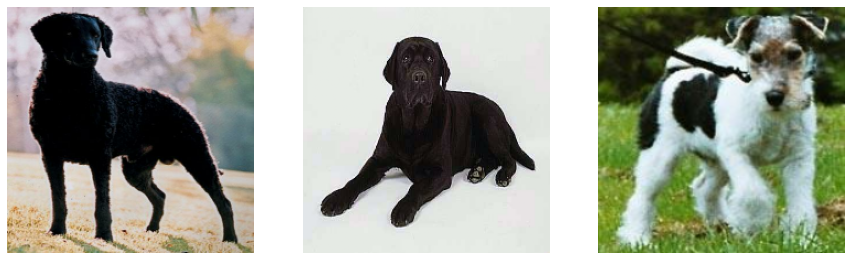

In [11]:
plt.figure(figsize=(15, 5))

for images,labels in ds_train_no_aug.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        ax.imshow(images[i])
        plt.axis("off")
    break

In [12]:
# 기본 resmodel
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [13]:
# qugmentation으로 학습할 모델 추가
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [14]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [15]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [16]:
resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


In [17]:
EPOCH = 10
batch_size = 128
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
93/93 [==============================] - 73s 216ms/step - loss: 4.4602 - accuracy: 0.0907 - val_loss: 5.3400 - val_accuracy: 0.0121
Epoch 2/10
93/93 [==============================] - 20s 212ms/step - loss: 2.9437 - accuracy: 0.2944 - val_loss: 8.5087 - val_accuracy: 0.0093
Epoch 3/10
93/93 [==============================] - 20s 218ms/step - loss: 2.3496 - accuracy: 0.4133 - val_loss: 7.3957 - val_accuracy: 0.0093
Epoch 4/10
93/93 [==============================] - 20s 214ms/step - loss: 1.9184 - accuracy: 0.4778 - val_loss: 6.0697 - val_accuracy: 0.0084
Epoch 5/10
93/93 [==============================] - 20s 211ms/step - loss: 1.8227 - accuracy: 0.4940 - val_loss: 5.4872 - val_accuracy: 0.0093
Epoch 6/10
93/93 [==============================] - 20s 211ms/step - loss: 1.5451 - accuracy: 0.5625 - val_loss: 5.1573 - val_accuracy: 0.0140
Epoch 7/10
93/93 [==============================] - 20s 214ms/step - loss: 1.4455 - accuracy: 0.5887 - val_loss: 4.6447 - val_accuracy: 0.0550

In [18]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
93/93 [==============================] - 28s 221ms/step - loss: 4.4296 - accuracy: 0.0867 - val_loss: 5.2126 - val_accuracy: 0.0056
Epoch 2/10
93/93 [==============================] - 20s 218ms/step - loss: 3.0437 - accuracy: 0.2776 - val_loss: 5.1453 - val_accuracy: 0.0065
Epoch 3/10
93/93 [==============================] - 20s 213ms/step - loss: 2.3581 - accuracy: 0.3858 - val_loss: 5.0839 - val_accuracy: 0.0093
Epoch 4/10
93/93 [==============================] - 20s 211ms/step - loss: 2.0504 - accuracy: 0.4543 - val_loss: 5.1274 - val_accuracy: 0.0121
Epoch 5/10
93/93 [==============================] - 20s 211ms/step - loss: 1.8054 - accuracy: 0.5074 - val_loss: 4.9596 - val_accuracy: 0.0093
Epoch 6/10
93/93 [==============================] - 20s 213ms/step - loss: 1.6523 - accuracy: 0.5504 - val_loss: 4.7788 - val_accuracy: 0.0261
Epoch 7/10
93/93 [==============================] - 20s 213ms/step - loss: 1.5077 - accuracy: 0.5726 - val_loss: 3.7713 - val_accuracy: 0.1493

In [19]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # Cut 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
93/93 [==============================] - 29s 222ms/step - loss: 4.8677 - accuracy: 0.0316 - val_loss: 6.0916 - val_accuracy: 0.0065
Epoch 2/10
93/93 [==============================] - 20s 218ms/step - loss: 4.4424 - accuracy: 0.0974 - val_loss: 5.5169 - val_accuracy: 0.0112
Epoch 3/10
93/93 [==============================] - 20s 214ms/step - loss: 4.1029 - accuracy: 0.1438 - val_loss: 5.5716 - val_accuracy: 0.0047
Epoch 4/10
93/93 [==============================] - 20s 213ms/step - loss: 3.8363 - accuracy: 0.1808 - val_loss: 5.9603 - val_accuracy: 0.0047
Epoch 5/10
93/93 [==============================] - 20s 213ms/step - loss: 3.5659 - accuracy: 0.2487 - val_loss: 5.2539 - val_accuracy: 0.0121
Epoch 6/10
93/93 [==============================] - 20s 214ms/step - loss: 3.5025 - accuracy: 0.2749 - val_loss: 5.1594 - val_accuracy: 0.0187
Epoch 7/10
93/93 [==============================] - 20s 215ms/step - loss: 3.3797 - accuracy: 0.2843 - val_loss: 4.2344 - val_accuracy: 0.1073

In [20]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # Cut 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 168s 214ms/step - loss: 3.7723 - accuracy: 0.2272 - val_loss: 3.7204 - val_accuracy: 0.1641
Epoch 2/10
750/750 [==============================] - 159s 213ms/step - loss: 2.9200 - accuracy: 0.4500 - val_loss: 1.4182 - val_accuracy: 0.5992
Epoch 3/10
750/750 [==============================] - 160s 213ms/step - loss: 2.6807 - accuracy: 0.5441 - val_loss: 1.4315 - val_accuracy: 0.6030
Epoch 4/10
750/750 [==============================] - 159s 213ms/step - loss: 2.4923 - accuracy: 0.6072 - val_loss: 1.2940 - val_accuracy: 0.6369
Epoch 5/10
750/750 [==============================] - 160s 213ms/step - loss: 2.3913 - accuracy: 0.6460 - val_loss: 1.2687 - val_accuracy: 0.6460
Epoch 6/10
750/750 [==============================] - 160s 213ms/step - loss: 2.2990 - accuracy: 0.6826 - val_loss: 1.2543 - val_accuracy: 0.6472
Epoch 7/10
750/750 [==============================] - 159s 213ms/step - loss: 2.2342 - accuracy: 0.7119 - val_loss: 1.4515 -

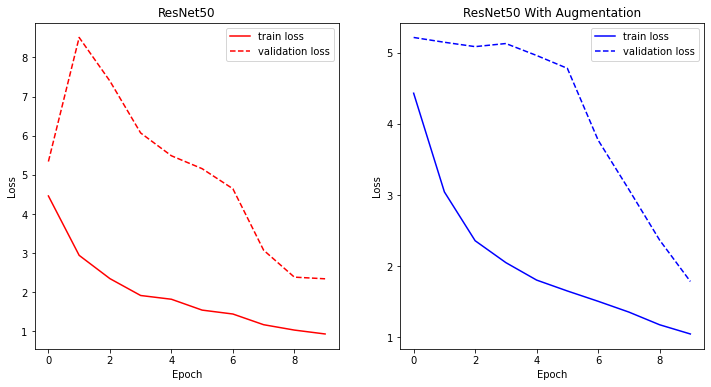

In [21]:
# 각 모델의 train loss와 validation loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_resnet50_no_aug.history['loss'], 'r')
ax1.plot(history_resnet50_no_aug.history['val_loss'], '--r')
ax1.set_title('ResNet50')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['train loss', 'validation loss'], loc='upper right')

ax2.plot(history_resnet50_aug.history['loss'], 'b')
ax2.plot(history_resnet50_aug.history['val_loss'], '--b')
ax2.set_title('ResNet50 With Augmentation')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train loss', 'validation loss'], loc='upper right')


plt.show()

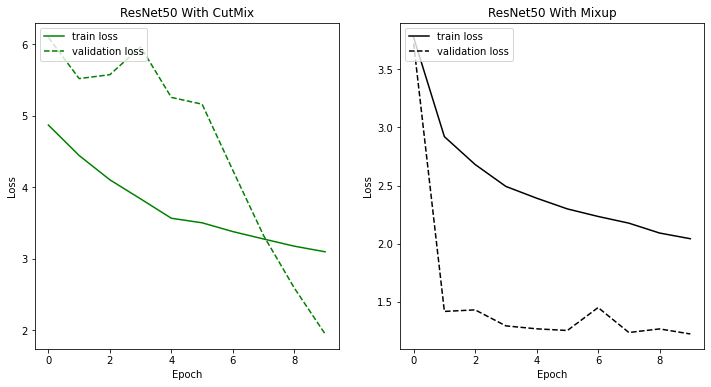

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_resnet50_cutmix.history['loss'], 'g')
ax1.plot(history_resnet50_cutmix.history['val_loss'], '--g')
ax1.set_title('ResNet50 With CutMix')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['train loss', 'validation loss'], loc='upper left')

ax2.plot(history_resnet50_mixup.history['loss'], 'k')
ax2.plot(history_resnet50_mixup.history['val_loss'], '--k')
ax2.set_title('ResNet50 With Mixup')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train loss', 'validation loss'], loc='upper left')

plt.show()

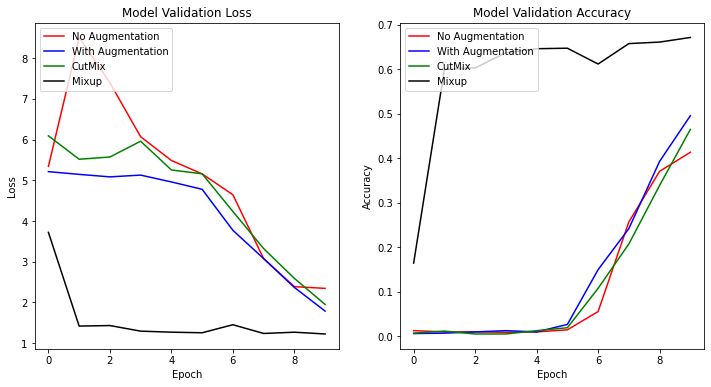

In [23]:
# 4가지 모델의 학습 결과 확인
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_resnet50_no_aug.history['val_loss'], 'r')
ax1.plot(history_resnet50_aug.history['val_loss'], 'b')
ax1.plot(history_resnet50_cutmix.history['val_loss'], 'g')
ax1.plot(history_resnet50_mixup.history['val_loss'], 'k')
ax1.set_title('Model Validation Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'Mixup'], loc='upper left')

ax2.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
ax2.plot(history_resnet50_aug.history['val_accuracy'], 'b')
ax2.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
ax2.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
ax2.set_title('Model Validation Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'Mixup'], loc='upper left')

plt.show()

# 후기
자꾸 데이터 라벨에서 문제가 발생해서 확인 해봤는데 데이터를 불러올때 as_supervised=True을 안켜서 2-튜플 구조(입력, 레이블)를 안가져와서 그랬다....
아니면 내가 함수에서 받아올때 받는 값을 바꿔서
```python
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    # Normalize and resize image function
    def normalize_and_resize_img(image, label):
        image = tf.image.resize(image, [224, 224])
        return tf.cast(image, tf.float32) / 255., label
        ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
        
    ds = ds.batch(batch_size)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds 
```
이런식으로 바꿔야 했다.
오답은 있어도 해결할 방법은 많다.